# K-means

This notebook showcases unsupervised learning on a phishing email dataset using sklearn's `KMeans` class.

## Libraries

In [ ]:
# If you do not have stopwords
import nltk
nltk.download("stopwords")

In [1]:
from nltk.corpus import stopwords

import pandas as pd

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../")
from env import DATA, SEED, preprocess

Check if the `phsihing_email_cleaned.zip` file is available in the current directory.

If not, run the `EDA.ipynb` notebook to preprocess the dataset and save it as `phishing_email_cleaned.csv`.

In [ ]:
!if [ ! -f "{DATA}/phishing_email_cleaned.zip" ]; then echo "File not found! Run EDA.ipynb preprocessing first."; exit 1; fi

## Step 0: Preprocessing

This step is partly completed in the `EDA.ipynb` notebook. We will then encode the text data in the pipeline.

In [2]:
emails = pd.read_csv(f"{DATA}/phishing_email_cleaned.zip", compression="zip")
emails = emails[emails["label"] == 1]

emails["text"] = emails["text"].astype(str)
emails["cleaned_text"] = emails["text"].apply(preprocess)

emails.drop("text", axis=1, inplace=True)

In [3]:
emails.tail(5)

,label,cleaned_text
18634,1,congratulations you have won pls contact your ...
18637,1,empty
18638,1,strong buy alert monthly newsletter topstocks ...
18645,1,date a lonely housewife always wanted to date ...
18649,1,empty


In [4]:
# Remove english stop words and useless words
useless_words = ["http", "com", "www", "spamassassin", "font", "arial", "empty", "none", "ˆì", "½ï", "ˆë"]
words_to_remove = stopwords.words("english") + useless_words

vectorizer = TfidfVectorizer(stop_words=words_to_remove, ngram_range=(1, 2), max_df=0.9, max_features=3000)

X = vectorizer.fit_transform(emails["cleaned_text"])

## Step 1: Find The Best Cluster Amount

In [5]:
def find_optimal_clusters(X, max_k=10):
    wcss = []
    silhouette_scores = []
    ch_scores = []
    db_scores = []

    K_range = range(2, max_k + 1)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=SEED)
        labels = kmeans.fit_predict(X)
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, labels))
        ch_scores.append(calinski_harabasz_score(X.toarray(), labels))
        db_scores.append(davies_bouldin_score(X.toarray(), labels))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(K_range, wcss, "bo-", markersize=8)
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("WCSS (Inertia)")
    plt.title("Elbow Method")

    plt.subplot(1, 2, 2)
    plt.plot(K_range, silhouette_scores, "ro-", markersize=8)
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Analysis (Higher is better)")

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(K_range, ch_scores, "go-", markersize=8)
    plt.title("Calinski-Harabasz Index (Higher is better)")
    plt.xlabel("Number of clusters k")
    plt.ylabel("Score")

    plt.subplot(1, 2, 2)
    plt.plot(K_range, db_scores, "mo-", markersize=8)
    plt.title("Davies-Bouldin Index (Lower is better)")
    plt.xlabel("Number of clusters k")
    plt.ylabel("Score")


    plt.tight_layout()
    plt.show()

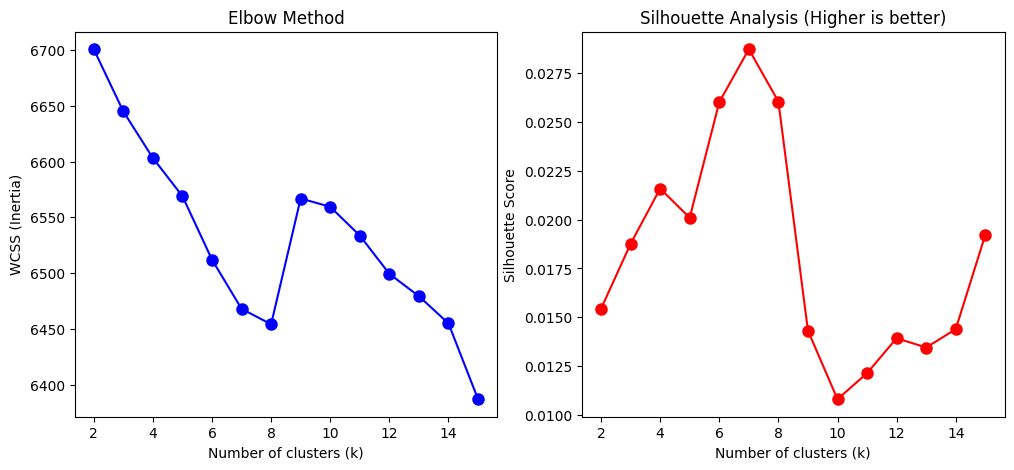

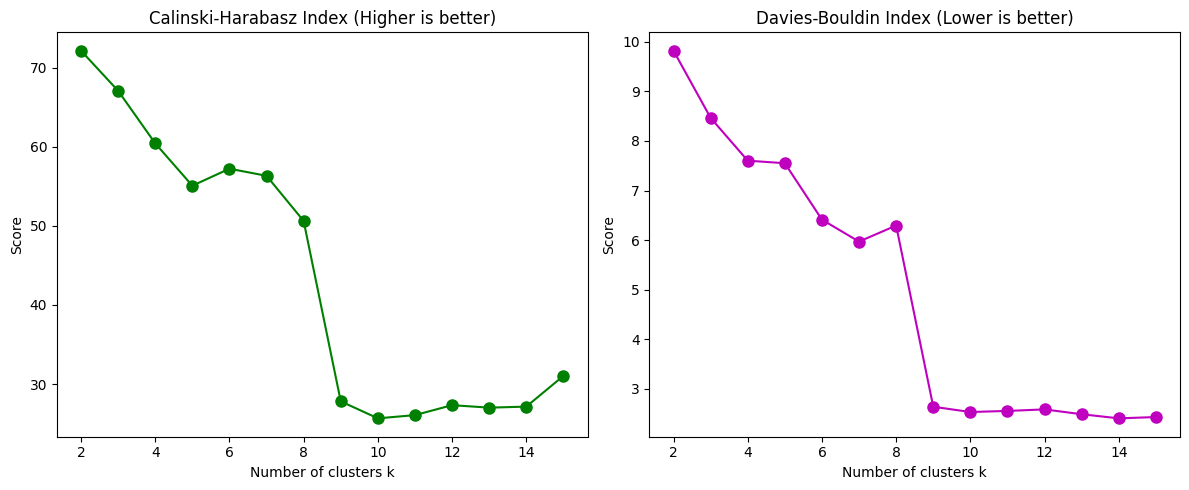

In [6]:
find_optimal_clusters(X, 15)

To select the best number of clusters for the K-means algorithm, multiple cluster quality metrics were evaluated over a range of cluster counts (k from 2 to 15):

- **Within-Cluster Sum of Squares (WCSS)**: Measures cluster compactness; lower values indicate tighter clusters. The "elbow" point in the WCSS plot suggests a good trade-off between the number of clusters and compactness.

- **Silhouette Score**: Ranges from -1 to 1, with higher values indicating better-defined and well-separated clusters.

- **Calinski-Harabasz Index**: Higher scores represent better cluster separation and compactness.

- **Davies-Bouldin Index**: Measures the average similarity between clusters; lower values indicate better clustering.

By analyzing these metrics together — the elbow in the WCSS plot, peaks in the Silhouette and Calinski-Harabasz scores, and a low Davies-Bouldin score — it was determined that **7 clusters** provide the best balance of compactness and separation for this phishing email dataset.


## Step 2: Fitting On The Desired Cluster Amount

In [7]:
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
kmeans.fit(X)

,n_clusters,7
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


## Step 3: Evaluation

In [8]:
emails["cluster"] = kmeans.labels_

In [9]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

### Clustering Graph Display

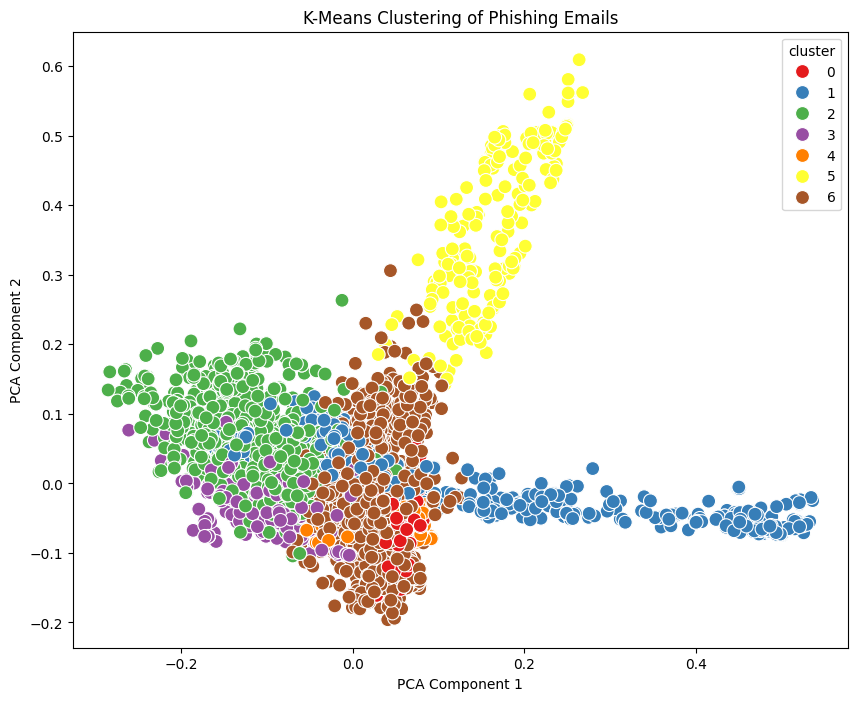

In [10]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 1], y=X_pca[:, 2], hue=emails["cluster"], palette="Set1", s=100, edgecolors="w", marker="o")
plt.title("K-Means Clustering of Phishing Emails")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

### Identified Clusters

In [11]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(n_clusters):
    print(f"Cluster {i}:")
    print(", ".join([terms[ind] for ind in order_centroids[i, :15]]))
    print("\n")


Cluster 0:
de, rolex, utf, medications, promotional, stop, watches, material, medication, stop receiving, replicas, para, quality, que, en


Cluster 1:
company, statements, report, money, account, investment, bank, may, transaction, information, securities, million, us, security, mr


Cluster 2:
email, click, free, please, list, mail, remove, removed, get, receive, address, us, information, mailing, message


Cluster 3:
credit, mortgage, rate, rates, loan, home, website, low, form, refinance, fill, click, get, fixed, application


Cluster 4:
logo, business, stationery, company, competitors, creative, image, identity, design, see, hot, breath, hand, business make, success


Cluster 5:
adobe, software, xp, windows, professional, pro, mx, softwares, photoshop, microsoft, macromedia, office, windows xp, xp professional, corel


Cluster 6:
get, viagra, online, save, new, want, best, order, day, info, one, like, man, meds, cialis




### Evaluation of Detected Clusters

The K-means algorithm identified **7 distinct clusters** in the phishing email dataset, each representing a specific phishing theme:

- **Cluster 0: Counterfeit and Promotional Scams**  
  Contains words like *rolex*, *replicas*, *promotional*, *medication*, and *quality*. This cluster represents phishing emails that promote counterfeit goods and fake products, often trying to lure victims with fake luxury watches or unauthorized medications.

- **Cluster 1: Financial and Investment Scams**  
  Includes terms such as *company*, *investment*, *transaction*, *bank*, *money*, and *securities*. This cluster reflects phishing emails targeting victims with fraudulent financial offers, fake bank statements, or bogus investment schemes designed to steal money or sensitive information.

- **Cluster 2: General Phishing and Email Manipulation**  
  Composed of words like *email*, *click*, *free*, *remove*, and *mailing*. These emails typically use common phishing tactics, such as urging recipients to click malicious links, unsubscribe from lists, or provide personal information through deceptive messaging.

- **Cluster 3: Loan and Credit Scams**  
  Contains keywords such as *credit*, *mortgage*, *loan*, *refinance*, and *application*. This cluster highlights phishing emails offering fake loan or mortgage refinancing deals, often attempting to collect sensitive financial or personal data from recipients.

- **Cluster 4: Business and Corporate Identity Scams**  
  Includes words like *logo*, *business*, *identity*, *design*, and *competitors*. These emails may impersonate companies or use branding elements to deceive recipients, commonly seen in business email compromise (BEC) or corporate phishing attacks.

- **Cluster 5: Software and Technology Scams**  
  Features terms like *adobe*, *windows*, *photoshop*, *office*, and *microsoft*. This cluster points to phishing campaigns targeting software users, such as fake software updates, license key scams, or malware disguised as legitimate programs.

- **Cluster 6: Pharmaceutical and Online Drug Scams**  
  Contains words including *viagra*, *cialis*, *online*, *meds*, and *order*. This cluster represents spam emails that promote unauthorized or illegal online drug sales, often aimed at soliciting purchases of counterfeit or unsafe medications.

These distinct clusters illustrate how phishing emails can be grouped by theme, revealing the diverse strategies scammers use.


## Conclusion

This analysis demonstrates the effectiveness of K-means clustering in uncovering distinct themes within a phishing email dataset. By evaluating multiple cluster quality metrics, an optimal number of **7 clusters** was identified, each representing a specific phishing tactic such as counterfeit goods, financial fraud, loan scams, business impersonation, software-related scams, and pharmaceutical spam.

The resulting clusters provide valuable insights into the common strategies used by cybercriminals, enabling better understanding and classification of phishing attempts. These findings can inform the development of more targeted detection and prevention methods, enhancing email security and reducing the risk posed by phishing attacks.
